# **Plot Growth Curves - Cuvette**

In [52]:
# Load packages
library(dplyr)
library(tidyr)
library(hms)
library(lubridate)
library(ggplot2)
library(purrr)
library(tidyverse)
library(cowplot)
library(readr)
library(patchwork)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


The following object is masked from ‘package:lubridate’:

    stamp




In [53]:
od_tp <- read_tsv("od600_tp.tsv")
head(od_tp)
tail(od_tp)

Rows: 312 Columns: 5
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Strain, Carbon
dbl (3): Time_hr, OD600, Replicate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Time_hr,OD600,Strain,Carbon,Replicate
<dbl>,<dbl>,<chr>,<chr>,<dbl>
0,0.06,AH1253,M9_GLU,1
0,0.06,AH1253,M9_GLU,2
0,0.03,AH1253,M9_GLU,3
0,0.10,AH1253,M9_SIA,1
0,0.10,AH1253,M9_SIA,2
0,0.10,AH1253,M9_SIA,3


Time_hr,OD600,Strain,Carbon,Replicate
<dbl>,<dbl>,<chr>,<chr>,<dbl>
72,0.25,AH1956,M9_GMP,1
72,0.21,AH1956,M9_GMP,2
72,0.23,AH1956,M9_GMP,3
72,0.45,AH1956,M9,1
72,0.45,AH1956,M9,2
72,0.44,AH1956,M9,3


Ignoring unknown labels:
• colour : "Strain"


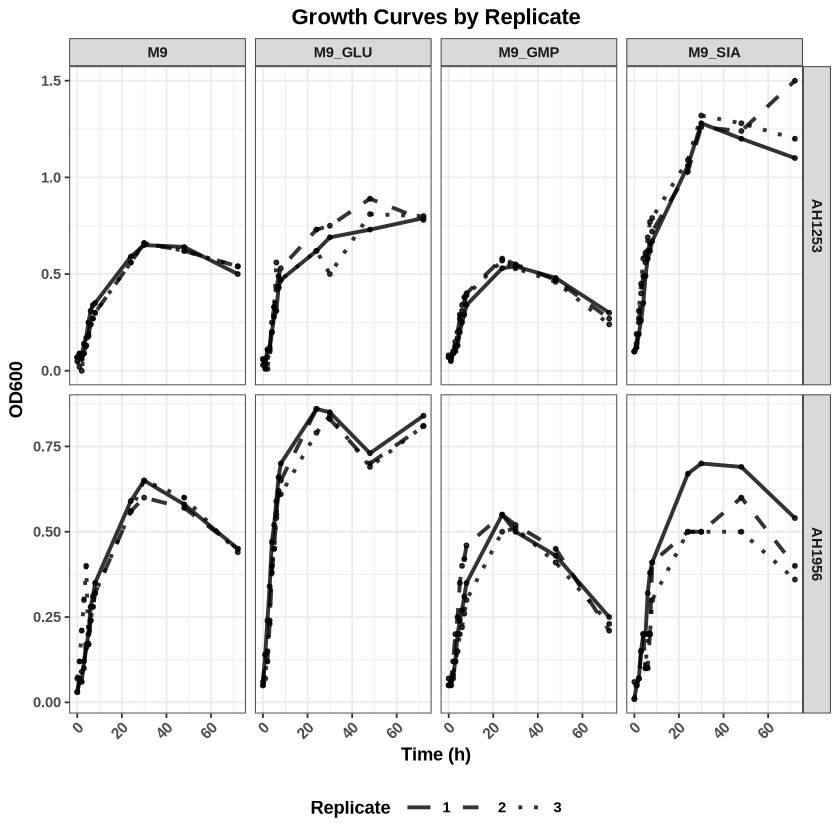

In [54]:
# Plot: one curve per replicate, panels organized by Strain × Carbon
rep_plot <- ggplot(od_tp, aes(
  x = Time_hr,
  y = OD600,
  linetype = factor(Replicate),  # use linetype aesthetic here
  group = interaction(Strain, Carbon, Replicate)
)) +
  geom_point(size = 1, alpha = 0.8) +
  geom_line(size = 1.1, alpha = 0.8) +  # Thicker lines
  facet_grid(Strain ~ Carbon, scales = "free_y") +
  labs(
    x = "Time (h)",
    y = "OD600",
    color = "Strain",
    linetype = "Replicate",
    title = "Growth Curves by Replicate"
  ) +
  scale_linetype_manual(values = c("solid", "dashed", "dotted")) +  
  theme_bw() +
  theme(
    text = element_text(face = "bold"),
    strip.text = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
    axis.text.y = element_text(face = "bold"),
    plot.title = element_text(face = "bold", hjust = 0.5),
    legend.position = "bottom"
  )

rep_plot

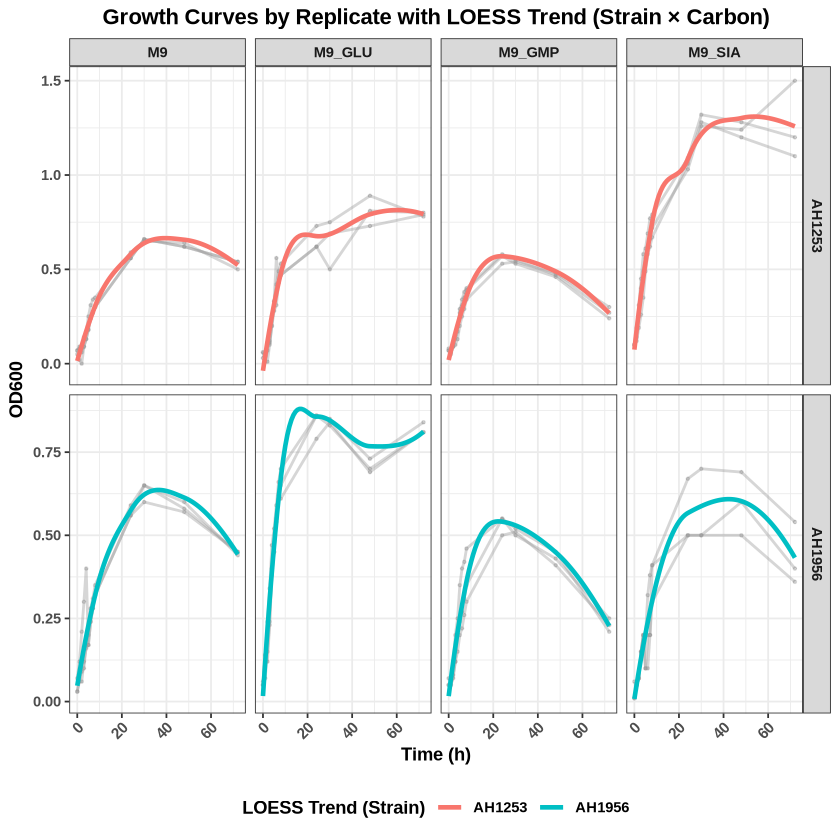

In [55]:
# Get overall growth trend with LOESS
rep_plot2 <- ggplot(od_tp, aes(
  x = Time_hr,
  y = OD600
)) +
  # Individual replicate curves (transparent gray)
  geom_line(aes(group = interaction(Strain, Carbon, Replicate)),
            color = "gray60", size = 0.8, alpha = 0.4) +
  geom_point(aes(group = interaction(Strain, Carbon, Replicate)),
             color = "gray60", size = 0.6, alpha = 0.4) +

  # LOESS trend across all three replicates (per Strain × Carbon)
  geom_smooth(
    aes(color = Strain, group = interaction(Strain, Carbon)),
    method = "loess",
    formula = y ~ x,
    se = FALSE,
    size = 1.3,
    span = 0.8,
    alpha = 0.9
  ) +

  facet_grid(Strain ~ Carbon, scales = "free_y") +
  labs(
    x = "Time (h)",
    y = "OD600",
    color = "LOESS Trend (Strain)",
    title = "Growth Curves by Replicate with LOESS Trend (Strain × Carbon)"
  ) +
  theme_bw() +
  theme(
    text = element_text(face = "bold"),
    strip.text = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
    axis.text.y = element_text(face = "bold"),
    plot.title = element_text(face = "bold", hjust = 0.5),
    legend.position = "bottom"
  )

rep_plot2

In [56]:
# Aggregate OD600 by Strain, Carbon, and Time
od_tp_summary <- od_tp %>%
  group_by(Strain, Carbon, Time_hr) %>%
  summarise(
    mean_OD = mean(OD600, na.rm = TRUE),
    sd_OD = sd(OD600, na.rm = TRUE),
    se_OD = sd_OD / sqrt(n()),   # standard error
    .groups = "drop"
  )

head(od_tp_summary)

Strain,Carbon,Time_hr,mean_OD,sd_OD,se_OD
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AH1253,M9,0,0.06333333,0.01154701,0.006666667
AH1253,M9,1,0.06333333,0.03785939,0.021858128
AH1253,M9,2,0.04666667,0.04163332,0.024037009
AH1253,M9,3,0.10666667,0.02886751,0.016666667
AH1253,M9,4,0.14333333,0.02309401,0.013333333
AH1253,M9,5,0.20333333,0.04041452,0.023333333


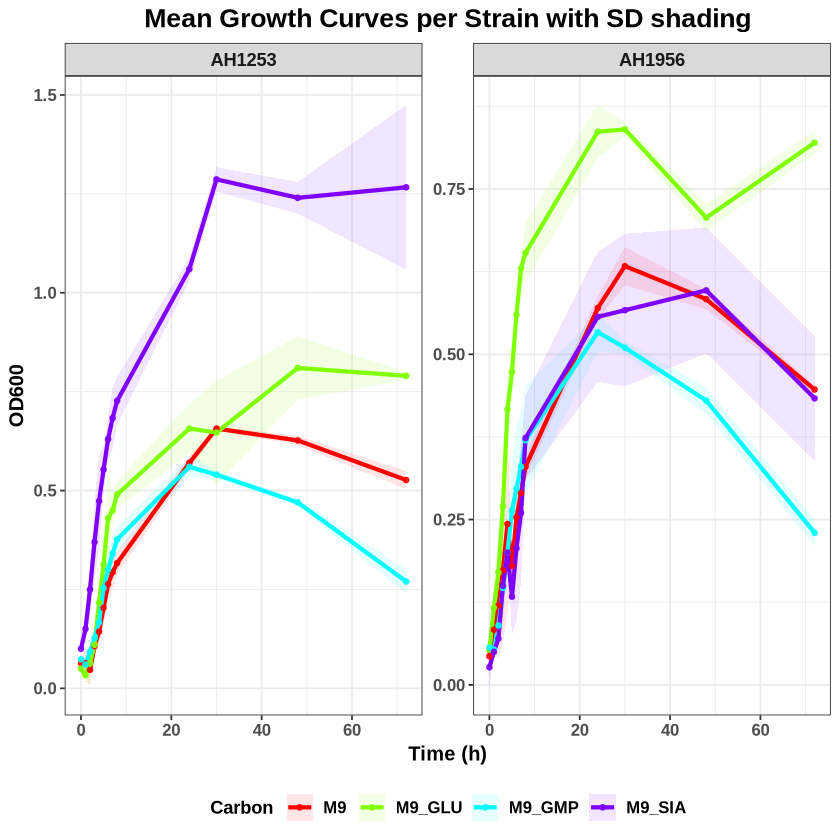

In [47]:
# Example custom colors (adjust length to match number of Carbon sources)
carbon_colors <- rainbow(length(unique(od_tp_summary$Carbon)))

plot_od_log <- ggplot(od_tp_summary, aes(
  x = Time_hr,
  y = mean_OD,
  ymin = mean_OD - sd_OD,
  ymax = mean_OD + sd_OD,
  color = Carbon,
  fill = Carbon,
  group = Carbon
)) +
  # Ribbon for SD (transparent)
  geom_ribbon(alpha = 0.1, color = NA) +  

  # Smooth line through mean OD
  geom_line(size = 1.2) +  

  # Points for mean OD
  geom_point(size = 1.2, alpha = 0.9) +  

  # Facet per Strain
  facet_wrap(~ Strain, scales = "free_y") +

  # Axis labels and title
  ylab("OD600") + 
  xlab("Time (h)") +
  ggtitle("Mean Growth Curves per Strain with SD shading") +

  # Colors
  scale_color_manual(values = carbon_colors) +
  scale_fill_manual(values = carbon_colors) +

  # Classic theme
  theme_bw() +
  theme(
    plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
    axis.title = element_text(face = "bold", size = 12),
    axis.text = element_text(face = "bold", size = 10),
    strip.text = element_text(face = "bold", size = 11),
    legend.title = element_text(face = "bold", size = 11),
    legend.text = element_text(face = "bold", size = 10),
    legend.position = "bottom"
  )

plot_od_log


In [63]:
# Compute summary stats per group
od_tp_summary_stats <- od_tp %>%
  group_by(Strain, Carbon, Time_hr) %>%
  summarise(
    mean_OD = mean(OD600, na.rm = TRUE),
    sd_OD = sd(OD600, na.rm = TRUE),
    se_OD = sd_OD / sqrt(n()),
    .groups = "drop"
  )

# Join summary stats back to original OD measurements
od_tp_summary <- od_tp %>%
  left_join(od_tp_summary_stats, by = c("Strain", "Carbon", "Time_hr"))

od_tp_summary

Time_hr,OD600,Strain,Carbon,Replicate,mean_OD,sd_OD,se_OD
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.06,AH1253,M9_GLU,1,0.05000000,0.017320508,0.010000000
0,0.06,AH1253,M9_GLU,2,0.05000000,0.017320508,0.010000000
0,0.03,AH1253,M9_GLU,3,0.05000000,0.017320508,0.010000000
0,0.10,AH1253,M9_SIA,1,0.10000000,0.000000000,0.000000000
0,0.10,AH1253,M9_SIA,2,0.10000000,0.000000000,0.000000000
0,0.10,AH1253,M9_SIA,3,0.10000000,0.000000000,0.000000000
0,0.07,AH1253,M9_GMP,1,0.07333333,0.005773503,0.003333333
0,0.08,AH1253,M9_GMP,2,0.07333333,0.005773503,0.003333333
0,0.07,AH1253,M9_GMP,3,0.07333333,0.005773503,0.003333333


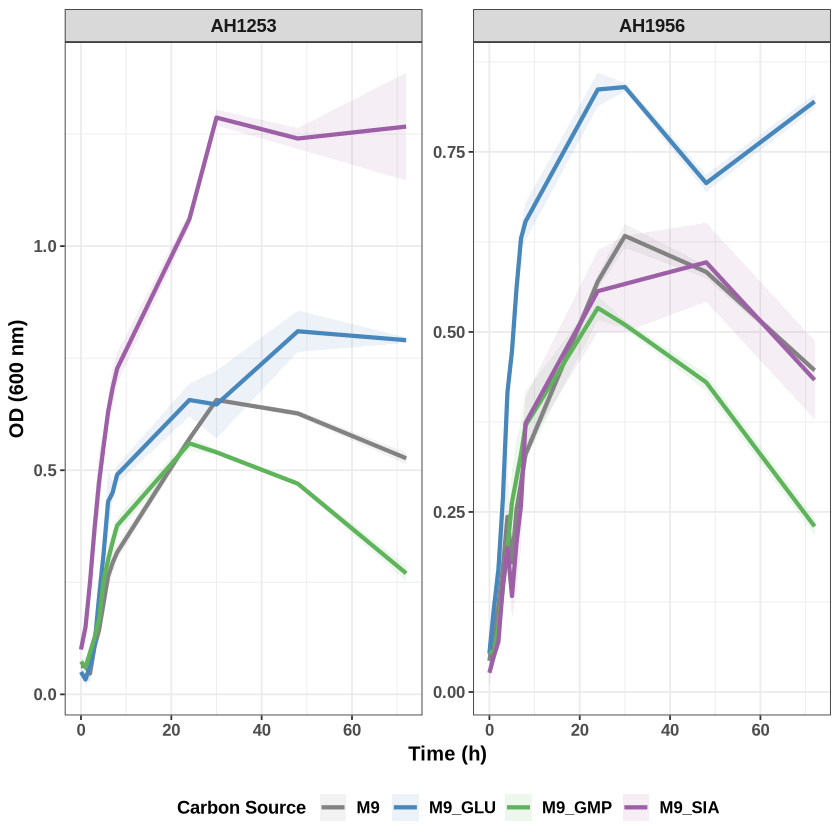

In [85]:
# Plot
plot_od_combined <- ggplot() +
  # Ribbon for mean ± SE
  geom_ribbon(data = od_tp_summary,
              aes(x = Time_hr, ymin = mean_OD - se_OD, ymax = mean_OD + se_OD,
                  fill = Carbon),
              alpha = 0.1, color = NA) +  # slightly transparent, no border

  # Line through the mean
  geom_line(data = od_tp_summary,
            aes(x = Time_hr, y = mean_OD, color = Carbon, group = Carbon),
            size = 1.2) +

  # Facet per strain
  facet_wrap(~ Strain, scales = "free_y") +

  # Colors
  scale_color_manual(values = c("M9_GLU" = "#4787bb",
                                "M9_SIA" = "#9d5fa6",
                                "M9_GMP" = "#5eb35b",
                                "M9"     = "#828282")) +
  scale_fill_manual(values = c("M9_GLU" = "#4787bb",
                               "M9_SIA" = "#9d5fa6",
                               "M9_GMP" = "#5eb35b",
                               "M9"     = "#828282")) +

  # Labels
  xlab("Time (h)") +
  ylab("OD (600 nm)") +
  labs(color = "Carbon Source", fill = "Carbon Source") +

  # Theme
  theme_bw() +
  theme(
    plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
    axis.title = element_text(face = "bold", size = 12),
    axis.text = element_text(face = "bold", size = 10),
    strip.text = element_text(face = "bold", size = 11),
    legend.title = element_text(face = "bold", size = 11),
    legend.text = element_text(face = "bold", size = 10),
    legend.position = "bottom"
  )

plot_od_combined

`geom_smooth()` using formula = 'y ~ x'


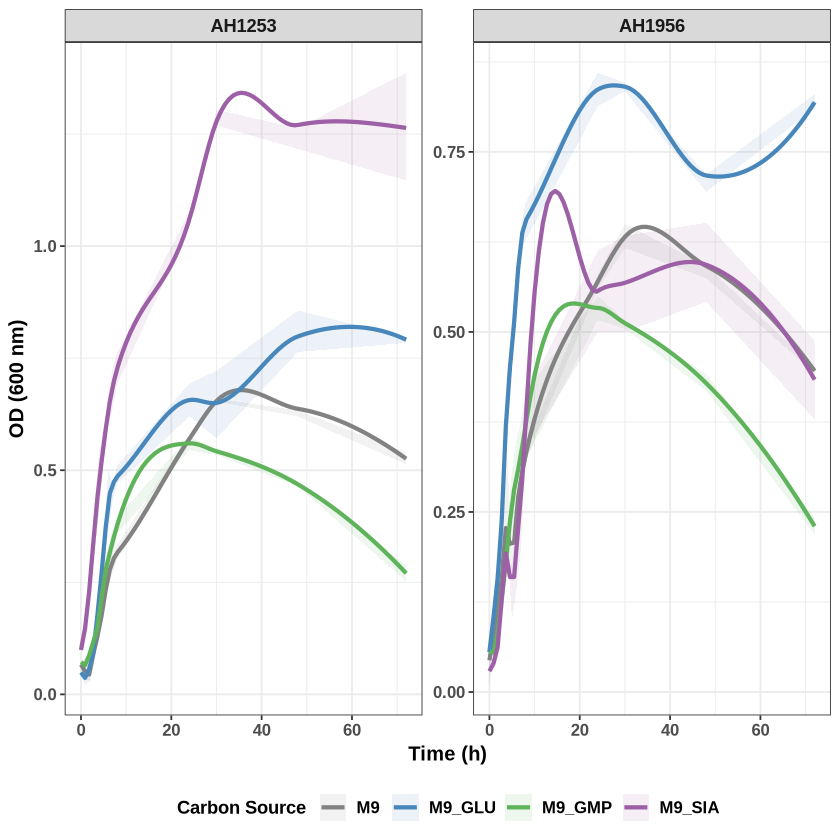

In [89]:
plot_od_trend <- ggplot() +
  # Ribbon for mean ± SE (optional, can also be removed)
  geom_ribbon(data = od_tp_summary,
              aes(x = Time_hr, ymin = mean_OD - se_OD, ymax = mean_OD + se_OD,
                  fill = Carbon),
              alpha = 0.1, color = NA) +

  # LOESS-smoothed trend across replicates
  geom_smooth(data = od_tp,
              aes(x = Time_hr, y = OD600, color = Carbon, group = Carbon),
              method = "loess", span = 0.4, se = FALSE, size = 1.2) +

  # Facet per strain
  facet_wrap(~ Strain, scales = "free_y") +

  # Colors
  scale_color_manual(values = c("M9_GLU" = "#4787bb",
                                "M9_SIA" = "#9d5fa6",
                                "M9_GMP" = "#5eb35b",
                                "M9"     = "#828282")) +
  scale_fill_manual(values = c("M9_GLU" = "#4787bb",
                               "M9_SIA" = "#9d5fa6",
                               "M9_GMP" = "#5eb35b",
                               "M9"     = "#828282")) +

  # Labels
  xlab("Time (h)") +
  ylab("OD (600 nm)") +
  labs(color = "Carbon Source", fill = "Carbon Source") +

  # Theme
  theme_bw() +
  theme(
    plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
    axis.title = element_text(face = "bold", size = 12),
    axis.text = element_text(face = "bold", size = 10),
    strip.text = element_text(face = "bold", size = 11),
    legend.title = element_text(face = "bold", size = 11),
    legend.text = element_text(face = "bold", size = 10),
    legend.position = "bottom"
  )

plot_od_trend

`geom_smooth()` using formula = 'y ~ x'


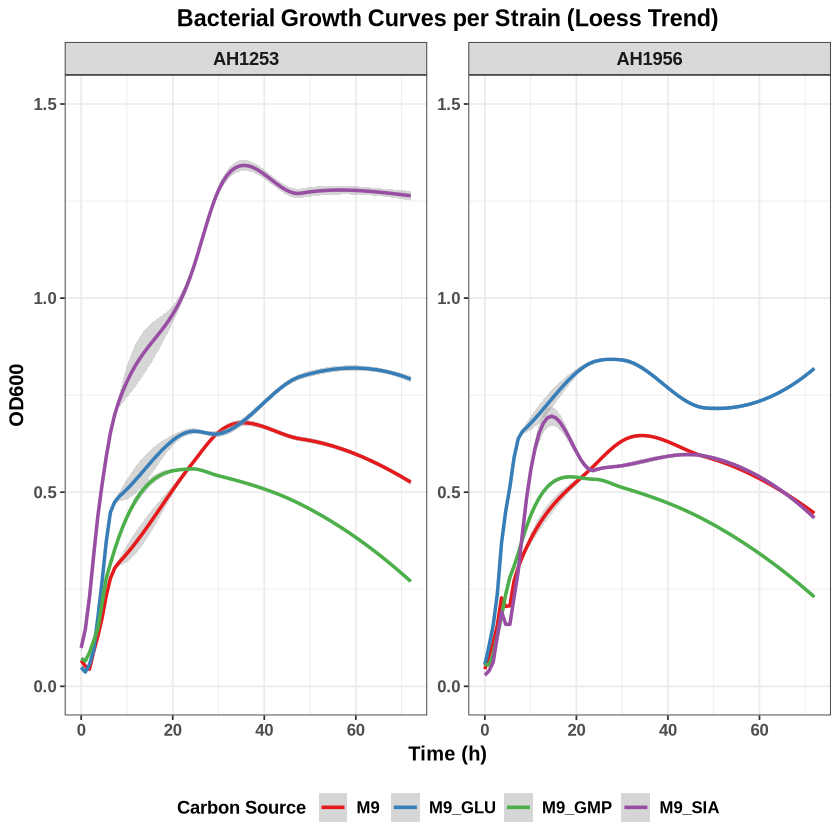

In [98]:
plot <- ggplot(od_tp_summary, aes(x = Time_hr, y = mean_OD)) +
  # # Raw measurements in light gray
  # geom_point(aes(group = well), color = "lightgray", size = 1.0, alpha = 0.7) +
  # Loess trend colored by Carbon
  geom_smooth(aes(color = Carbon, group = Carbon), 
              method = "loess", span = 0.4, se = TRUE, size = 1) +
  facet_wrap(~Strain, scales = "free_y") +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = "Time (h)",
    y = "OD600",
    color = "Carbon Source",
    title = "Bacterial Growth Curves per Strain (Loess Trend)"
  ) +
  scale_y_continuous(limits = c(0, 1.5)) +  # fix y-axis across all facets
  # coord_cartesian(xlim = c(0, 40)) +   # <- limits to 0–40h but keeps smoothing intact
  theme_bw() +
  theme(
    axis.title = element_text(face = "bold", size = 12),
    axis.text = element_text(face = "bold", size = 10),
    strip.text = element_text(face = "bold", size = 11),
    legend.title = element_text(face = "bold", size = 11),
    legend.text = element_text(face = "bold", size = 10),
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5), # centered bold title
    legend.position = "bottom"
  )

plot